In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from EMAN2 import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

In [9]:
train_gra=EMData()
train_gra.read_image("regions_24b_241_sz28.hdf")
train_data=to_numpy(train_gra).reshape(-1,28,28,1)
print(train_data.shape)

(7021, 28, 28, 1)


In [5]:
#train_data = np.concatenate((dense_241,dense_24b,alpha_241,alpha_24b),axis=0)
#train_label = np.concatenate((np.zeros(1450+736),np.ones(1494+1008)),dtype=np.float32)
#24b
#train_label = np.concatenate((2*np.ones(736),np.ones(1008),np.zeros(1949)))
#241
#train_label = np.concatenate((2*np.ones(1450),np.ones(1494),np.zeros(384)),dtype=np.float32)

In [10]:
train_label = np.concatenate((2*np.ones(736),np.ones(1008),np.zeros(1949),2*np.ones(1450),np.ones(1494),np.zeros(384)),dtype=np.float32)
print(train_data.shape,train_label.shape)

(7021, 28, 28, 1) (7021,)


In [11]:
x_train, y_train, x_test, y_test, x_val, y_val = three_way_split(dat=train_data,lab=train_label,test_split=0.2,val_split=0.1)

Training set shape: (4917, 28, 28, 1) (4917,) 
Test set shape: (1403, 28, 28, 1) (1403,)
Validate set shape: (701, 28, 28, 1) (701,)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(train_data,train_label,train_size=0.8)

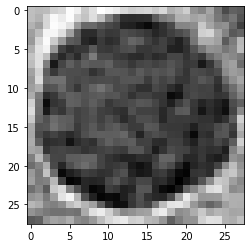

In [12]:
plt.imshow(train_data[0].squeeze(),cmap='gray')

[ 270  157  736  818  609  337 1323 1126  706  817 1370 1072 1254 1166
  906  286 1203 1357   66  712  756  798  901  928  907 1299   48  402
  692  701  129  837  773  267 1229  153  558  376  952  172 1371 1037
  393  570 1052  207   36  867]


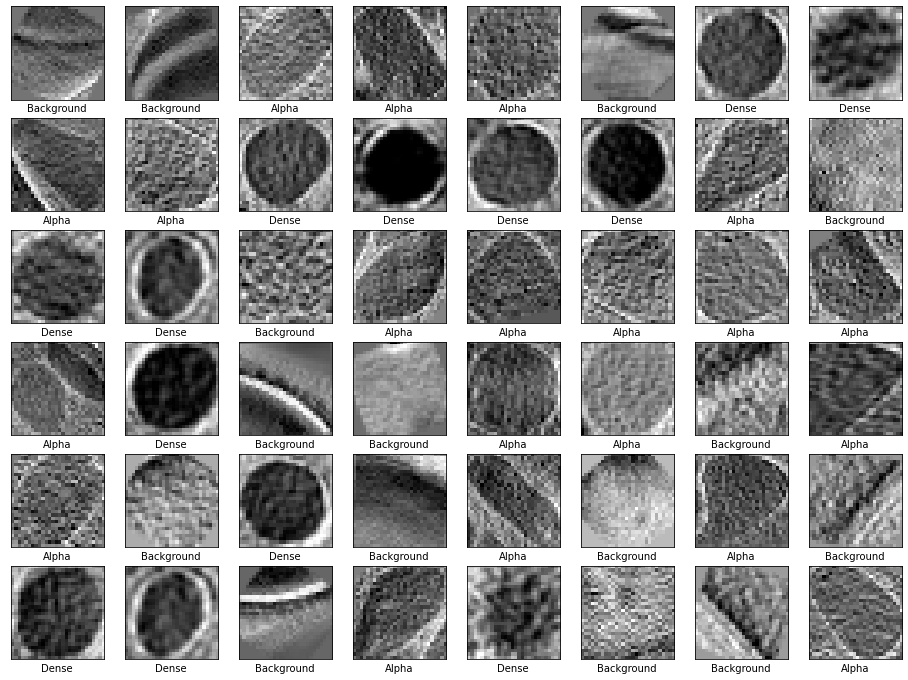

In [13]:
plot_dataset(x_test,y_test,nrow=6,ncol=8)

In [35]:
data_gen= tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)
data_gen.fit(x_train_val)

In [20]:
def build_l2(lr=1e-4,l2_loss_lambda=None):
    #loss_funct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    adam = Adam(lr=lr,decay=lr/100) 
    if l2_loss_lambda is None:
        l2 = None
    else: 
        l2 = tf.keras.regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)
    
    model = Sequential([ 
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2,
               input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(4, 4)),   
        
        Flatten(),
#         Dense(1024, activation='relu',kernel_regularizer=l2),
        Dense(32, activation='relu',kernel_regularizer=l2),
        Dense(16, activation='relu',kernel_regularizer=l2),
        Dense(3,activation='softmax')
        ])
    model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [15]:
model = build_l2(l2_loss_lambda=0.01)
print(model.summary())

Using L2 regularization - l2_loss_lambda = 0.0100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                50208     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 51,107
Trainable params: 51,107
Non-trainable params: 0
__

In [17]:
#x_train = x_train.reshape(-1,28,28,1)
#x_test = x_test.reshape(-1,28,28,1)

In [16]:
history = model.fit(x_train,y_train,batch_size=50,epochs=10,validation_data=(x_val,y_val),shuffle=True)

Train on 4917 samples, validate on 701 samples
Epoch 1/10
4917/4917 [==============================] - 2s 490us/sample - loss: 1.7621 - accuracy: 0.6380 - val_loss: 1.5126 - val_accuracy: 0.7233
Epoch 2/10
4917/4917 [==============================] - 1s 265us/sample - loss: 1.3222 - accuracy: 0.8241 - val_loss: 1.1670 - val_accuracy: 0.8673
Epoch 3/10
4917/4917 [==============================] - 1s 266us/sample - loss: 1.0527 - accuracy: 0.8892 - val_loss: 0.9594 - val_accuracy: 0.8930
Epoch 4/10
4917/4917 [==============================] - 1s 266us/sample - loss: 0.8829 - accuracy: 0.9105 - val_loss: 0.8242 - val_accuracy: 0.9058
Epoch 5/10
4917/4917 [==============================] - 1s 290us/sample - loss: 0.7706 - accuracy: 0.9237 - val_loss: 0.7294 - val_accuracy: 0.9158
Epoch 6/10
4917/4917 [==============================] - 2s 322us/sample - loss: 0.6901 - accuracy: 0.9319 - val_loss: 0.6595 - val_accuracy: 0.9330
Epoch 7/10
4917/4917 [==============================] - 2s 325us/

In [17]:
model.evaluate(x_test,y_test,verbose=0)

[0.5117570379123634, 0.93228793]

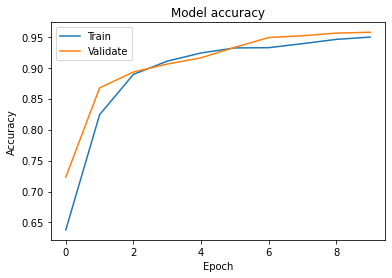

In [18]:
hist_plot(history)

In [21]:
test_512=EMData()
test_512.read_image("test_512_reg_lst.hdf")
test_512=to_numpy(test_512).reshape(-1,28,28,1)
print(test_512.shape)


(302, 28, 28, 1)


[ 45 138 254  75 134 171 199 264  90  19  81  60 219   0 111 277 214 132
 259 295 188  93 186  16 203  49 267 125 118  12 165 147 298 145  32  22
 278 204 179 168 155  56 175 100 108  54 187 126]


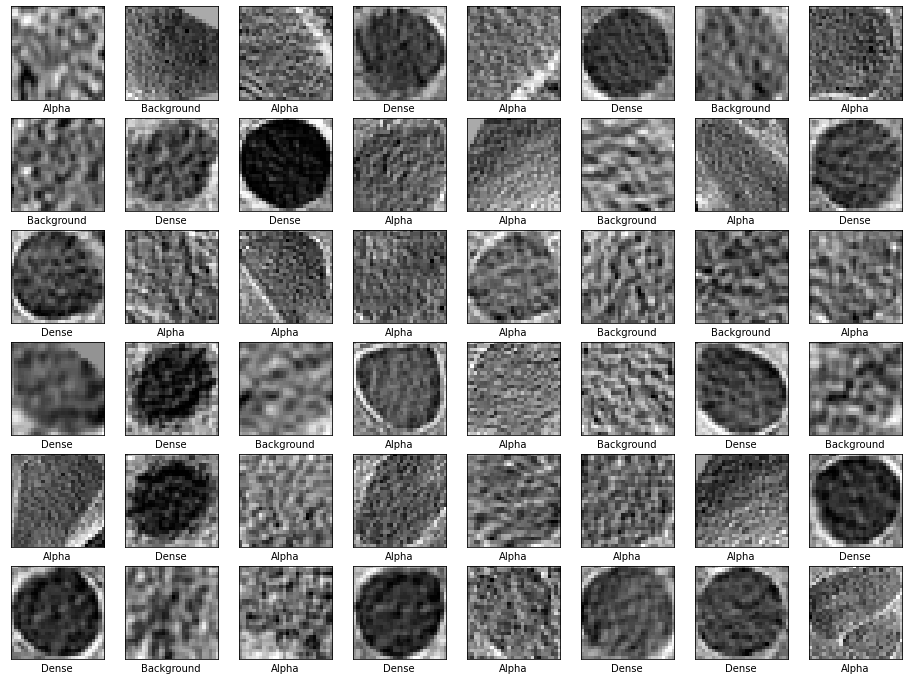

In [22]:
y_pred = model.predict_classes(test_512)
plot_dataset(test_512,y_pred,nrow=6,ncol=8)

In [27]:
score = model.evaluate(x_test, y_test,verbose=0)
score

[1.221534645260441, 0.43131673]

In [63]:
print((np.where((y_pred==y_train)))[0].shape)
print(y_train.shape)

(116522,)
(469,)


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_test, y_pred).numpy()

In [ ]:
history=model.fit(data_gen.flow(x_train_val, y_train_val,
         subset='training'),
         validation_data=data_gen.flow(x_train_val, y_train_val
         ,subset='validation'),epochs=20)

In [39]:
model.evaluate(x_test,y_test,verbose=0)

[1.1003379544696292, 0.5297297]

In [51]:
y_pred = np.argmax(y_pred,axis=1)

In [53]:
y_pred = (model.predict(x_test))
#bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#bce(y_test,y_pred).numpy()

In [100]:
train_data = EMData()
train_data.read_image("regions_24b_241_sz28.hdf")
train_data = to_numpy(train_data)
train_data.shape

(7021, 28, 28)

In [157]:
#train_label = np.concatenate((2*np.ones(1450),np.ones(1494),np.zeros(384)))
train_label = np.concatenate((2*np.ones(736),np.ones(1008),np.zeros(1949),2*np.ones(1450),np.ones(1494),np.zeros(384)),dtype=np.float32)
#train_label = np.concatenate((2*np.ones(1450),np.ones(1494),np.zeros(384)))
#train_label = np.concatenate((2*np.ones(736),np.ones(1008),np.zeros(1949)))
train_label.shape

(7021,)

In [4]:
train_label[0:5]

array([2., 2., 2., 2., 2.])

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))

In [64]:
dense_241.read_image("regions_241_dense_sz28.hdf")
dense_241 = to_numpy(dense_241)
print(dense_241.shape)

In [101]:
x_train_nofilt, x_test_nofilt, y_train_nofilt, y_test_nofilt = train_test_split(train_data, train_label,train_size=0.9)

In [104]:
x_train = np.concatenate((x_train,x_train_nofilt))
x_test = np.concatenate((x_test,x_test_nofilt))
y_train = np.concatenate((y_train,y_train_nofilt))
y_test = np.concatenate((y_test,y_test_nofilt))

In [156]:
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset


<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.float64)>

In [117]:
print(x_train.shape,y_train.shape)

(12636, 28, 28, 1) (12636,)


In [13]:
#class_names = ['Background','Alpha','Dense']

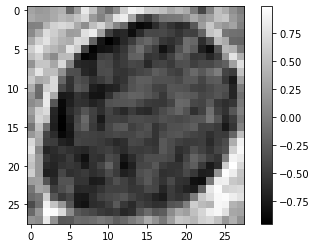

In [42]:
plt.figure()
plt.imshow(x_train[0].squeeze(),cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
plot_dataset(train_data,train_label,nrow=6,ncol=8)

[ 651  553  462 1143  867  578  755   72 1279 1238 1203  508  281 1283
  532  520 1360  616  704  301 1007   80  388  696  917 1168  355  208
  530  424 1260  576  428  495  654  848]


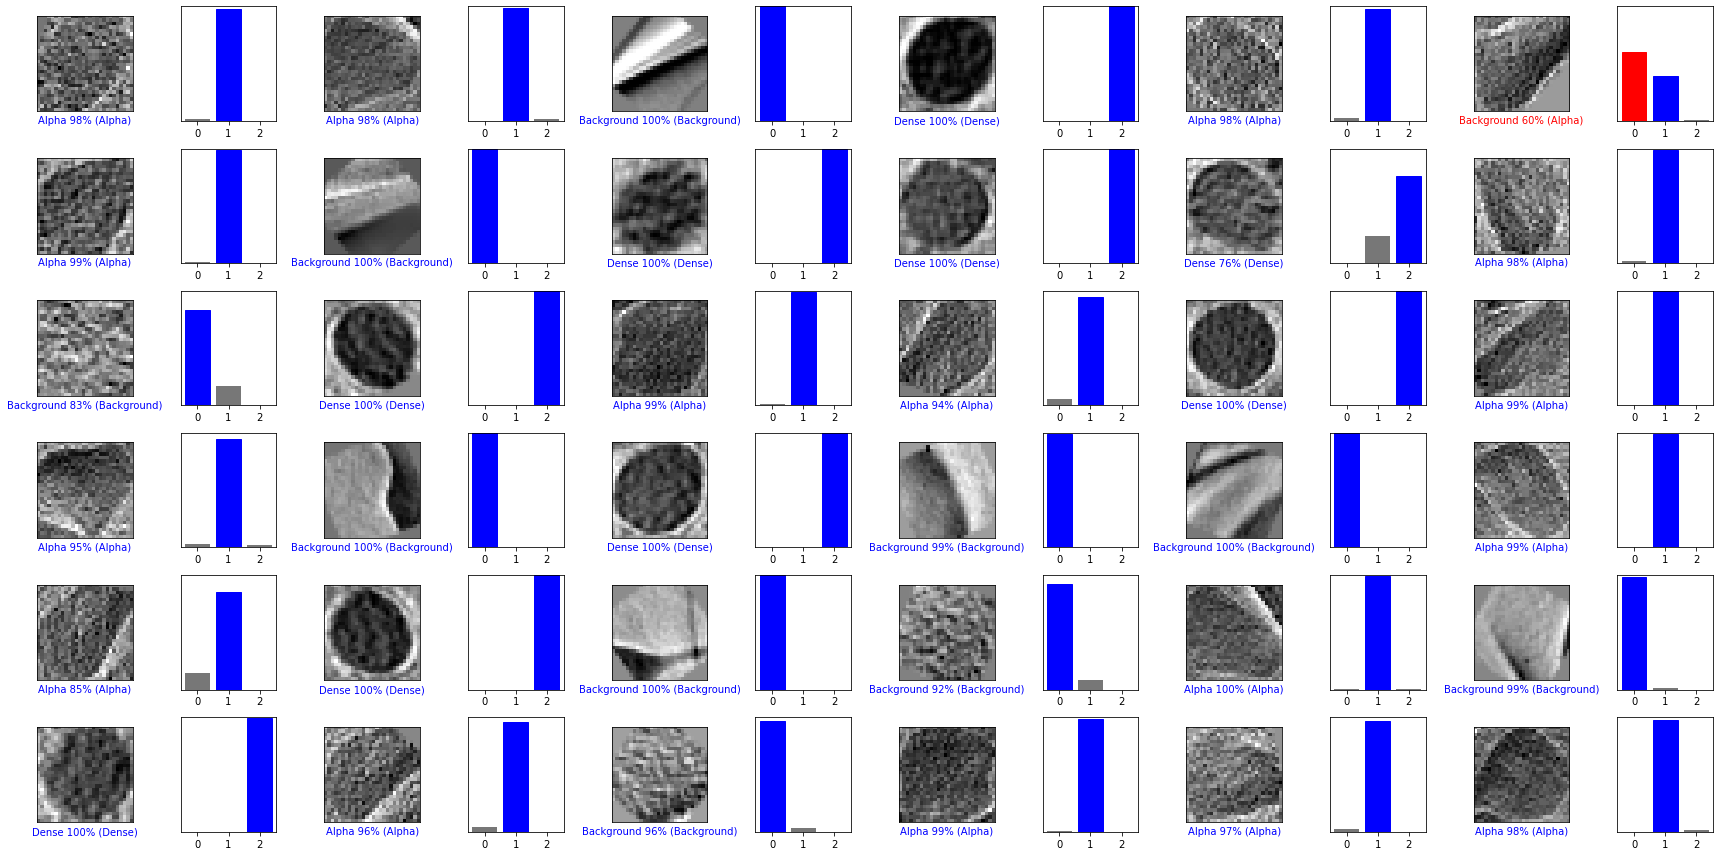

In [41]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
predictions = model.predict(x_test)
num_rows = 6
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
ind_arr = np.random.choice(len(y_test),num_images,replace=False)
print(ind_arr)
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(ind_arr[i], predictions[ind_arr[i]], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(ind_arr[i], predictions[ind_arr[i]], y_test)
plt.tight_layout()
plt.show()

In [119]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=1000,batch_size=50,callbacks=[rlrop],validation_data=(x_test, y_test))

In [ ]:
[sns.distplot(x_train[i].ravel()) for i in np.where(y_train==0)[0][:5]]


In [70]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
np.where(y_train==2)[0][:100]

array([3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879,
       3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890,
       3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901,
       3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912,
       3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923,
       3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934,
       3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945,
       3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956,
       3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967,
       3968])

In [15]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

370/1 - 0s - loss: 2.0539 - accuracy: 0.4784

Test accuracy: 0.4783784


In [205]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [30]:
predictions = model.predict(x_test)
predicted_label = []
for pred in predictions:
    predicted_label.append(np.argmax(pred))

In [243]:
np.max(predictions[0])

0.5021709

[[185 149 124]
 [136 241 138]
 [129 175 129]]


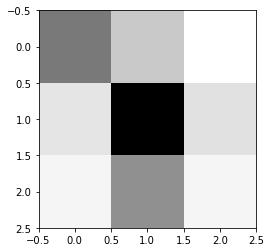

In [132]:
from sklearn.metrics import confusion_matrix
# Plot non-normalized confusion matrix

cm=confusion_matrix(y_test,predicted_label)
print(cm)
plt.imshow(cm, cmap='binary')

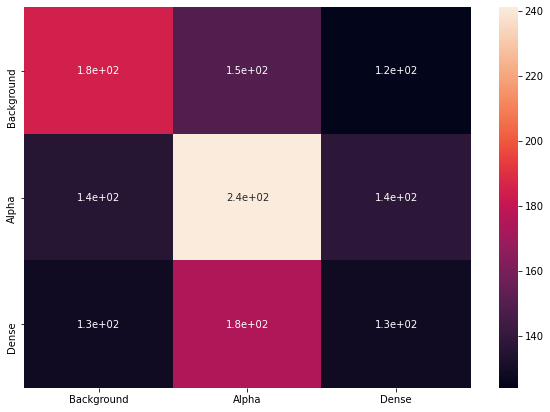

In [133]:
df_cm = pd.DataFrame(cm, index = ["Background","Alpha","Dense"],
                  columns = ["Background","Alpha","Dense"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [101]:
x =pd.DataFrame({'True':((y_test)),
                 'Predicted':predicted_label})
pd.set_option("display.max_rows", None, "display.max_columns", None)
x

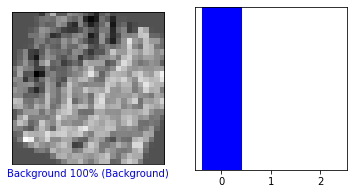

In [41]:
i = 150
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

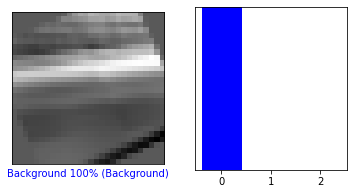

In [32]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

Helper functions

In [3]:
def eman2numpy(infile):
    temp = EMData()
    temp.read_image(infile)
    out = to_numpy(temp)
    print(out.shape)
    return out

In [4]:
def numpy2eman(input_np,outfile):
    from_numpy(input_np).write_image(outfile)
    print("Writing",outfile,"to disk.")   

In [5]:
def hist_plot(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.show()

In [6]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = int(true_label[i]), img[i].squeeze()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.gray)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = int(true_label[i])
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [7]:
def three_way_split(dat,lab,test_split,val_split=0,random_seed=111):
    #np.random.seed(random_seed)
    #train_data=train_data.reshape(-1,28,28,1)
    train_index =[]
    val_index=[]
    test_index = []
    for i in set(lab):
        ind_array=np.where(lab==i)[0]
        len_test=int(len(ind_array)*test_split)
        len_val=int(len(ind_array)*val_split)
        test_val_ind = np.random.choice(ind_array,size=(len_test+len_val),replace=False)
        #print("TVI:",test_val_ind)
        #print(len(test_val_ind))
        test_index.append(test_val_ind[0:len_test])
        val_index.append(test_val_ind[len_test:])
        train_index.append(np.asarray(list(set(ind_array)-set(test_val_ind))))
    train_index = np.concatenate([ele for ele in train_index])
    val_index = np.concatenate([ele for ele in val_index])
    test_index = np.concatenate([ele for ele in test_index])
    #np.random.shuffle(train_index)
    #np.random.shuffle(test_index)
    #print(train_index)
    #print(test_index)
    #print(val_index)
    del ind_array
    x_train = dat[train_index]
    y_train = lab[train_index]
    x_test = dat[test_index]
    y_test = lab[test_index]
    print("Training set shape:", x_train.shape,y_train.shape,
          "\nTest set shape:", x_test.shape,y_test.shape)
    if val_split!=0:
        #np.random.shuffle(val_index)
        x_val = dat[val_index]
        y_val = lab[val_index]
        print("Validate set shape:", x_val.shape,y_val.shape)
        return x_train, y_train, x_test, y_test, x_val, y_val
    else:
        return x_train, y_train, x_test, y_test

In [8]:
#plot examples from a dataset:
def plot_dataset(data_arr,lab_arr,ind_arr=None,nrow=8,ncol=8):
    class_names = ['Background','Alpha','Dense']
    #class_names = ['Dense','Alpha']
    plt.figure(figsize=(ncol*2,nrow*2))
    if ind_arr == None:
        ind_arr = np.random.choice(len(lab_arr),nrow*ncol,replace=False)
    else:
        ind_arr = ind_arr
    print(ind_arr)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data_arr[ind_arr[i]].squeeze(), cmap='gray')
        plt.xlabel(class_names[int(lab_arr[ind_arr[i]])])
        #plt.xlabel((lab_arr[ind_arr[i]]))
    plt.show()

TOYS 
-
-
-
-
-
-

In [11]:
x = np.asarray([10*i for i in range(20)])
y = np.asarray([i%3 for i in range(20)])
x_train, y_train, x_test, y_test, x_val,y_val = three_way_split(x,y,test_split=0.3,val_split=0.2) 

Training set shape: (12,) (12,) 
Test set shape: (5,) (5,)
Validate set shape: (3,) (3,)


In [12]:
print(x_val)
print(y_val)

print(x_test)
print(y_test)

print(x_train)
print(y_train)

print(x)
print(y)

[  0 160 110]
[0 1 2]
[ 60  90  40 130 170]
[0 0 1 1 2]
[180  30 120 150  10 100 190  70  80  20  50 140]
[0 0 0 0 1 1 1 1 2 2 2 2]
[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
[0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1]


In [8]:
#len(set(train_label))
l = []
a = np.where(train_label==1)[0]
b = np.random.choice(10, size=2, replace=False)
c = 10*np.arange(10)

In [78]:
(10*np.arange(20))[np.arange(10)[5:7]]

array([50, 60])

In [76]:
def alpha_dense():
    #loss_funct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    adam = Adam(lr=1e-4)
    model = Sequential([ 
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28,28,1)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        Dropout(0.3),
        
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2,activation='softmax')
        ])
    model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
history = model.fit(x_train,y_train,batch_size=100,epochs=200,validation_data=(x_val,y_val))

In [183]:
def build_l2(l2_loss_lambda=None):
    #loss_funct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    adam = Adam(lr=1e-4,decay=1e-6) 
    if l2_loss_lambda is None:
        l2 = None
    else: 
        l2 = tf.keras.regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)
    
    model = Sequential([ 
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               kernel_regularizer=l2,
               input_shape=(28,28,1)),
#         BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2),
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', 
               padding='same',kernel_regularizer=l2),
#         BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu',
              kernel_regularizer=l2),
#         BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', 
               padding='same',kernel_regularizer=l2),
#         BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu',
              kernel_regularizer=l2),
#         BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
#         Dense(1024, activation='relu',kernel_regularizer=l2),
        Dense(64, activation='relu',kernel_regularizer=l2),
        Dense(2,activation='softmax')
        ])
    model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [107]:
#np.random.seed(123)
x_train_val, x_test, y_train_val, y_test = train_test_split(train_data, train_label,train_size=0.9)

In [108]:
x_train_val = x_train_val.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)